# **Model Selection using RFE**
## Housing Case Study

#### Problem Statement:

Consider a real estate company that has a dataset containing the prices of properties in the Delhi region. It wishes to use the data to optimise the sale prices of the properties based on important factors such as area, bedrooms, parking, etc.

Essentially, the company wants —


- To identify the variables affecting house prices, e.g. area, number of rooms, bathrooms, etc.

- To create a linear model that quantitatively relates house prices with variables such as number of rooms, area, number of bathrooms, etc.

- To know the accuracy of the model, i.e. how well these variables can predict house prices.

**So interpretation is important!**

**Steps include:**

Step 1: Reading, understanding

Step 2: Visualise the data

Step 3: Prepare the data for modelling (test-train split, rescaling etc.)

Step 4: Split the data into test train model

Step 5: Build/Train the model

Step 6: Residual Analysis

Step 7: Make Predictions & Evaluation on the test set

## **Step 1: Reading and Understanding the Data**

Let us first import NumPy and Pandas and read the housing dataset

In [1]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Importing Housing.csv
housing = pd.read_csv('Housing.csv')

In [4]:
# Looking at the first five rows
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


## **Step 3: Data Preparation for Modelling**

- You can see that your dataset has many columns with values as 'Yes' or 'No'.

- But in order to fit a regression line, we would need numerical values and not string. Hence, we need to convert them to 1s and 0s, where 1 is a 'Yes' and 0 is a 'No'.

In [5]:
# List of variables to map

varlist =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# Defining the map function
def binary_map(x):
    return x.map({'yes': 1, "no": 0})

# Applying the function to the housing list
housing[varlist] = housing[varlist].apply(binary_map)

# OR Directly using lambda function
# housing[varlist] = housing[varlist].apply(lambda x: x.map({'yes':1 , 'no':0 }))

In [6]:
# Check the housing dataframe now

housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


### Dummy Variables

The variable `furnishingstatus` has three levels. We need to convert these levels into integer as well. For this, we will use something called `dummy variables`.

In [7]:
# Get the dummy variables for the feature 'furnishingstatus' and store it in a new variable - 'status'

status = pd.get_dummies(housing['furnishingstatus'])

# Check what the dataset 'status' looks like
status.head()

,furnished,semi-furnished,unfurnished
0,1,0,0
1,1,0,0
2,0,1,0
3,1,0,0
4,1,0,0


Now, you don't need three columns. You can drop the `furnished` column, as the type of furnishing can be identified with just the last two columns where —
- `00` will correspond to `furnished`
- `01` will correspond to `unfurnished`
- `10` will correspond to `semi-furnished`

In [8]:
# Let's drop the first column from status df using 'drop_first = True'
status = pd.get_dummies(housing['furnishingstatus'], drop_first = True)

# Add the results to the original housing dataframe
housing = pd.concat([housing, status], axis = 1)

# Now let's see the head of our dataframe.
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished,0,0


In [9]:
# Drop 'furnishingstatus' as we have created the dummies for it
housing.drop(['furnishingstatus'], axis = 1, inplace = True)

housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


## **Step 4: Splitting the Data into Training and Testing Sets**

As you know, the first basic step for regression is performing a train-test split.

In [10]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively

df_train, df_test = train_test_split(housing, train_size = 0.7, test_size = 0.3, random_state = 100)

### Rescaling the Features

As you saw in the demonstration for Simple Linear Regression, scaling doesn't impact your model. Here we can see that except for `area`, all the columns have small integer values. So it is extremely important to rescale the variables so that they have a comparable scale. If we don't have comparable scales, then some of the coefficients as obtained by fitting the regression model might be very large or very small as compared to the other coefficients. This might become very annoying at the time of model evaluation. So it is advised to use standardization or normalization so that the units of the coefficients obtained are all on the same scale. As you know, there are two common ways of rescaling:

1. Min-Max scaling (Normalisation)
2. Standardisation (mean-0, sigma-1)

This time, we will use MinMax scaling.

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [12]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

df_train.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
359,0.169697,0.155227,0.4,0.0,0.000000,1,0,0,0,0,0.333333,0,0,1
19,0.615152,0.403379,0.4,0.5,0.333333,1,0,0,0,1,0.333333,1,1,0
159,0.321212,0.115628,0.4,0.5,0.000000,1,1,1,0,1,0.000000,0,0,0
35,0.548133,0.454417,0.4,0.5,1.000000,1,0,0,0,1,0.666667,0,0,0
28,0.575758,0.538015,0.8,0.5,0.333333,1,0,1,1,0,0.666667,0,0,1


### Dividing into X and Y sets for the model building

In [13]:
y_train = df_train.pop('price')
X_train = df_train

## **Step 5: Building a linear model**

Fit a regression line through the training data using `statsmodels`. Remember that in `statsmodels`, you need to explicitly fit a constant using `sm.add_constant(X)` because if we don't perform this step, `statsmodels` fits a regression line passing through the origin, by default.

This time, we will be using the **LinearRegression function from SciKit Learn** for its compatibility with RFE (which is a utility from sklearn)

### RFE
Recursive feature elimination

In [14]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()

rfe = RFE(estimator = lm, n_features_to_select = 10)             # Running RFE

rfe = rfe.fit(X_train, y_train)

In [16]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('area', True, 1),
 ('bedrooms', True, 1),
 ('bathrooms', True, 1),
 ('stories', True, 1),
 ('mainroad', True, 1),
 ('guestroom', True, 1),
 ('basement', False, 3),
 ('hotwaterheating', True, 1),
 ('airconditioning', True, 1),
 ('parking', True, 1),
 ('prefarea', True, 1),
 ('semi-furnished', False, 4),
 ('unfurnished', False, 2)]

In [17]:
col = X_train.columns[rfe.support_]
col

Index(['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom',
       'hotwaterheating', 'airconditioning', 'parking', 'prefarea'],
      dtype='object')

In [18]:
X_train.columns[~rfe.support_]

Index(['basement', 'semi-furnished', 'unfurnished'], dtype='object')

### Building model using statsmodel, for the detailed statistics

In [20]:
import statsmodels.api as sm

# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

# Adding a constant variable
X_train_rfe = sm.add_constant(X_train_rfe)

lm = sm.OLS(y_train, X_train_rfe)
lm_model = lm.fit()

print(lm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     74.89
Date:                Wed, 25 Oct 2023   Prob (F-statistic):           1.28e-82
Time:                        12:42:08   Log-Likelihood:                 374.65
No. Observations:                 381   AIC:                            -727.3
Df Residuals:                     370   BIC:                            -683.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0027      0.018     

`Bedrooms` is insignificant in presence of other variables; can be dropped

In [21]:
X_train_new = X_train_rfe.drop(["bedrooms"], axis = 1)

Rebuilding the model without `bedrooms`

In [22]:
# Adding a constant variable
import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train_new)

lm = sm.OLS(y_train, X_train_sm)

lm_model = lm.fit()

print(lm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     82.37
Date:                Wed, 25 Oct 2023   Prob (F-statistic):           6.67e-83
Time:                        12:42:08   Log-Likelihood:                 373.00
No. Observations:                 381   AIC:                            -726.0
Df Residuals:                     371   BIC:                            -686.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0242      0.013     

In [24]:
X_train_new = X_train_new.drop(["const"], axis=1)

lm = sm.OLS(y_train, X_train_new)
lm_model = lm.fit()
print(lm_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.910
Model:                            OLS   Adj. R-squared (uncentered):              0.908
Method:                 Least Squares   F-statistic:                              417.6
Date:                Wed, 25 Oct 2023   Prob (F-statistic):                   1.99e-188
Time:                        12:42:08   Log-Likelihood:                          371.36
No. Observations:                 381   AIC:                                     -724.7
Df Residuals:                     372   BIC:                                     -689.2
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

### **Checking VIF**

Variance Inflation Factor or VIF, gives a basic quantitative idea about how much the feature variables are correlated with each other. It is an extremely important parameter to test our linear model. The formula for calculating `VIF` is:

### $ VIF_i = \frac{1}{1 - {R_i}^2} $

Three cases may arise --

- High p, High VIF - **`Definately Drop`**
- High , Low:
    - High p, Low VIF : `Remove these first`
    - Low p, High VIF : `Remove these after the ones above`
- Low p, Low VIF - **`Definately Keep`**

In [25]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,area,4.52
3,mainroad,4.26
2,stories,2.12
7,parking,2.10
6,airconditioning,1.75
1,bathrooms,1.58
8,prefarea,1.47
4,guestroom,1.30
5,hotwaterheating,1.12


Now as you can see, the VIFs and p-values both are within an acceptable range. So we go ahead and make our predictions using this model only.

## **Step 6: Residual Analysis of the train data**

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [26]:
y_train_pred = lm_model.predict(X_train_new)

In [27]:
# Importing the required libraries for plots.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

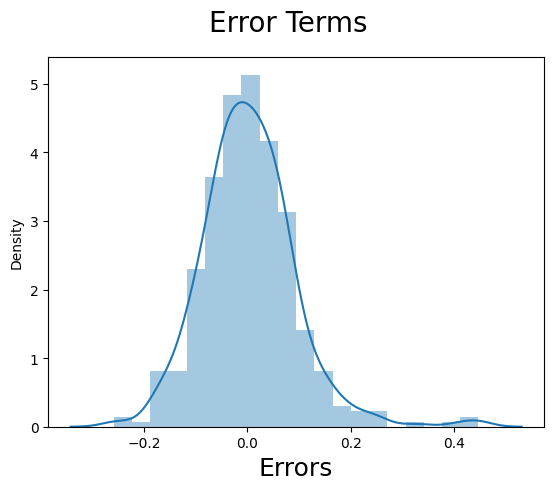

In [38]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading
plt.xlabel('Errors', fontsize = 18)                         # X-label
plt.show()

## **Step 7: Making Predictions Using the Final Model**

Now that we have fitted the model and checked the normality of error terms, it's time to go ahead and make predictions using the final, i.e. fourth model.

#### Applying the scaling on the test sets

In [33]:
num_vars = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']

df_test[num_vars] = scaler.transform(df_test[num_vars])

#### Dividing into X_test and y_test

In [34]:
y_test = df_test.pop('price')
X_test = df_test

In [35]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]


In [36]:
 # Making predictions
y_pred = lm_model.predict(X_test_new)

## **Step 8: Model Evaluation**

Let's now plot the graph for actual versus predicted values.

Text(0, 0.5, 'y_pred')

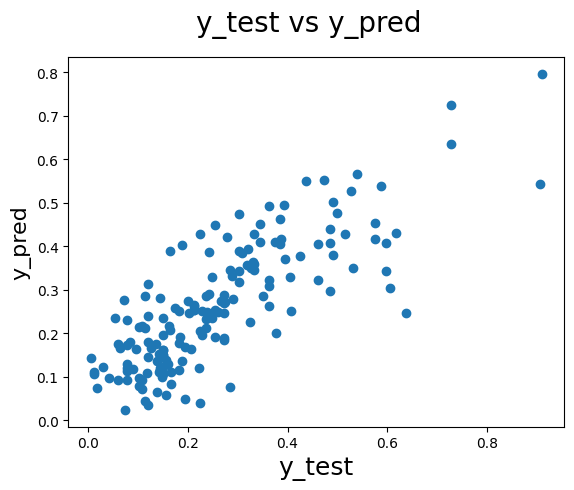

In [37]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label